In [1]:
#функція для виводу моделей
import matplotlib.pyplot as plt

def show_histories(histories):
    num_configs = len(histories)
    columns = 3
    rows = (num_configs // columns) + (num_configs % columns > 0)
    
    # Візуалізація точності (accuracy)
    fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))
    axes = axes.flatten()
    
    for idx, (key, history) in enumerate(histories.items()):
        ax = axes[idx]
        
        # Перевірка наявності даних для валідаційної точності
        if 'accuracy' in history and 'val_accuracy' in history:
            ax.plot(history['accuracy'], label='Train Accuracy')
            ax.plot(history['val_accuracy'], label='Validation Accuracy')
        else:
            ax.plot(history['accuracy'], label='Train Accuracy')
            ax.plot(history.get('val_accuracy', []), label='Validation Accuracy (Not Available)')
        
        ax.set_title(f'Model Accuracy - {key}')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper left')
    
    # Видалення порожніх підграфіків
    for i in range(len(histories), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

    # Візуалізація втрат (loss)
    fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 4))
    axes = axes.flatten()
    
    for idx, (key, history) in enumerate(histories.items()):
        ax = axes[idx]
        
        # Перевірка наявності даних для валідаційних втрат
        if 'loss' in history and 'val_loss' in history:
            ax.plot(history['loss'], label='Train Loss')
            ax.plot(history['val_loss'], label='Validation Loss')
        else:
            ax.plot(history['loss'], label='Train Loss')
            ax.plot(history.get('val_loss', []), label='Validation Loss (Not Available)')
        
        ax.set_title(f'Model Loss - {key}')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(loc='upper left')
    
    # Видалення порожніх підграфіків
    for i in range(len(histories), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()


In [2]:
# Перебір параметрів NN
# додано шум в градієнт та зміну LR
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

# Параметри моделі
loss_f = 'binary_crossentropy'
metrics = 'accuracy'

df = pd.read_csv('cleaned_remaining_na_-1.csv')  # Замініть на ваш файл даних

X = df.drop(columns=['id', 'churn'])
y = df['churn']

# Поділ на тренувальний, тестовий та валідаційний набори
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Словник для зберігання історії тренувань
histories = {}

dropout_rate = 0.0 # 0.3,0.4 не маэ сенсу. завжди гірше
# activation_functions=['tanh','sigmoid','relu']

# Вкладені цикли для перебору параметрів
for layers in [2, 3]: # 1,4,5,7 - не має сенсу. завжди гірше
    for units in [512, 1024]: # 32,64,256 - не має сенсу (завжди гірше). чим більше тим краще (32-128). 2048 - занадто довго
        for activation in ['tanh', 'relu']:   #'sigmoid' - нижче показники
            for batch_size in [4,8]:  # кращі результати при 32 [32, 64, 128]. чим нижче - тим краще

                # Створення моделі
                model = Sequential()
                model.add(InputLayer(shape=(X_train_scaled.shape[1],)))
                # model.add(GaussianNoise(0.1))                 # Додавання шуму - з ним результати гірші

                for _ in range(layers):
                    model.add(Dense(units, activation=activation)) #, activation='relu'
                    model.add(Dropout(dropout_rate))

                model.add(Dense(1, activation='sigmoid'))
                
                # Використання динамічного зменшення швидкості навчання
                model.compile(loss=loss_f, optimizer='adam', metrics=[metrics])

                # Друк інформації про модель
                print('---------------------------------------')
                print(f"Training model with layers: {layers}, units: {units}, dropout: {dropout_rate}, batch_size: {batch_size}, activation: {activation}")

                # Early stopping та learning rate scheduler
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

                # Тренування моделі
                history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                                    epochs=100, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], verbose=0) #callbacks=[early_stopping, reduce_lr]

                # Збереження історії
                key = f"layers={layers}_units={units}_dropout={dropout_rate}_batch_size={batch_size}_activation={activation}"
                histories[key] = history.history

                # Оцінка моделі на тестових даних
                y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
                accuracy = accuracy_score(y_test, y_pred)
                print(f"Test Accuracy for {key}: {accuracy}")

# Виведення історій навчання (для прикладу)
for key, history in histories.items():
    print(f"{key}: {history['val_loss'][-1]:.4f}")


2024-09-01 13:52:34.254567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 13:52:34.572800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-01 13:52:35.031446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 13:52:35.381748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 13:52:35.460632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 13:52:35.498416: I tensorflow/core/platform/cpu_feature_gu

---------------------------------------
Training model with layers: 2, units: 512, dropout: 0.0, batch_size: 4, activation: tanh
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
Test Accuracy for layers=2_units=512_dropout=0.0_batch_size=4_activation=tanh: 0.937036350148368
---------------------------------------
Training model with layers: 2, units: 512, dropout: 0.0, batch_size: 8, activation: tanh
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
Test Accuracy for layers=2_units=512_dropout=0.0_batch_size=8_activation=tanh: 0.9356454005934718
---------------------------------------
Training model with layers: 2, units: 512, dropout: 0.0, batch_size: 4, activation: relu
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
Test Accuracy for layers=2_units=512_dropout=0.0_batch_size=4_activation=relu: 0.9337908011869436
---------------------------------------
Training model with layers: 2, units: 512, dropout: 0.0, batch_size: 8, activation: relu
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
Test Accuracy for l

KeyboardInterrupt: 

In [4]:
# вивід таблиці значень

import pandas as pd
from IPython.display import display, HTML

def histories_to_dataframe(histories):
    # Створюємо порожній список для зберігання даних
    data = []
    
    for key, history in histories.items():
        data.append({
            'Model': key,
            'Final Train Accuracy': history['accuracy'][-1] if 'accuracy' in history else None,
            'Final Val Accuracy': history['val_accuracy'][-1] if 'val_accuracy' in history else None,
            'Final Train Loss': history['loss'][-1] if 'loss' in history else None,
            'Final Val Loss': history['val_loss'][-1] if 'val_loss' in history else None,
        })
    
    df = pd.DataFrame(data)
    return df
df_histories = histories_to_dataframe(histories)

# Виведення таблиці на всю ширину
pd.set_option('display.max_columns', None)  # Показати всі стовпці
pd.set_option('display.expand_frame_repr', False)  # Не переносити на новий рядок

display(HTML(df_histories.to_html(index=False)))

NameError: name 'histories' is not defined

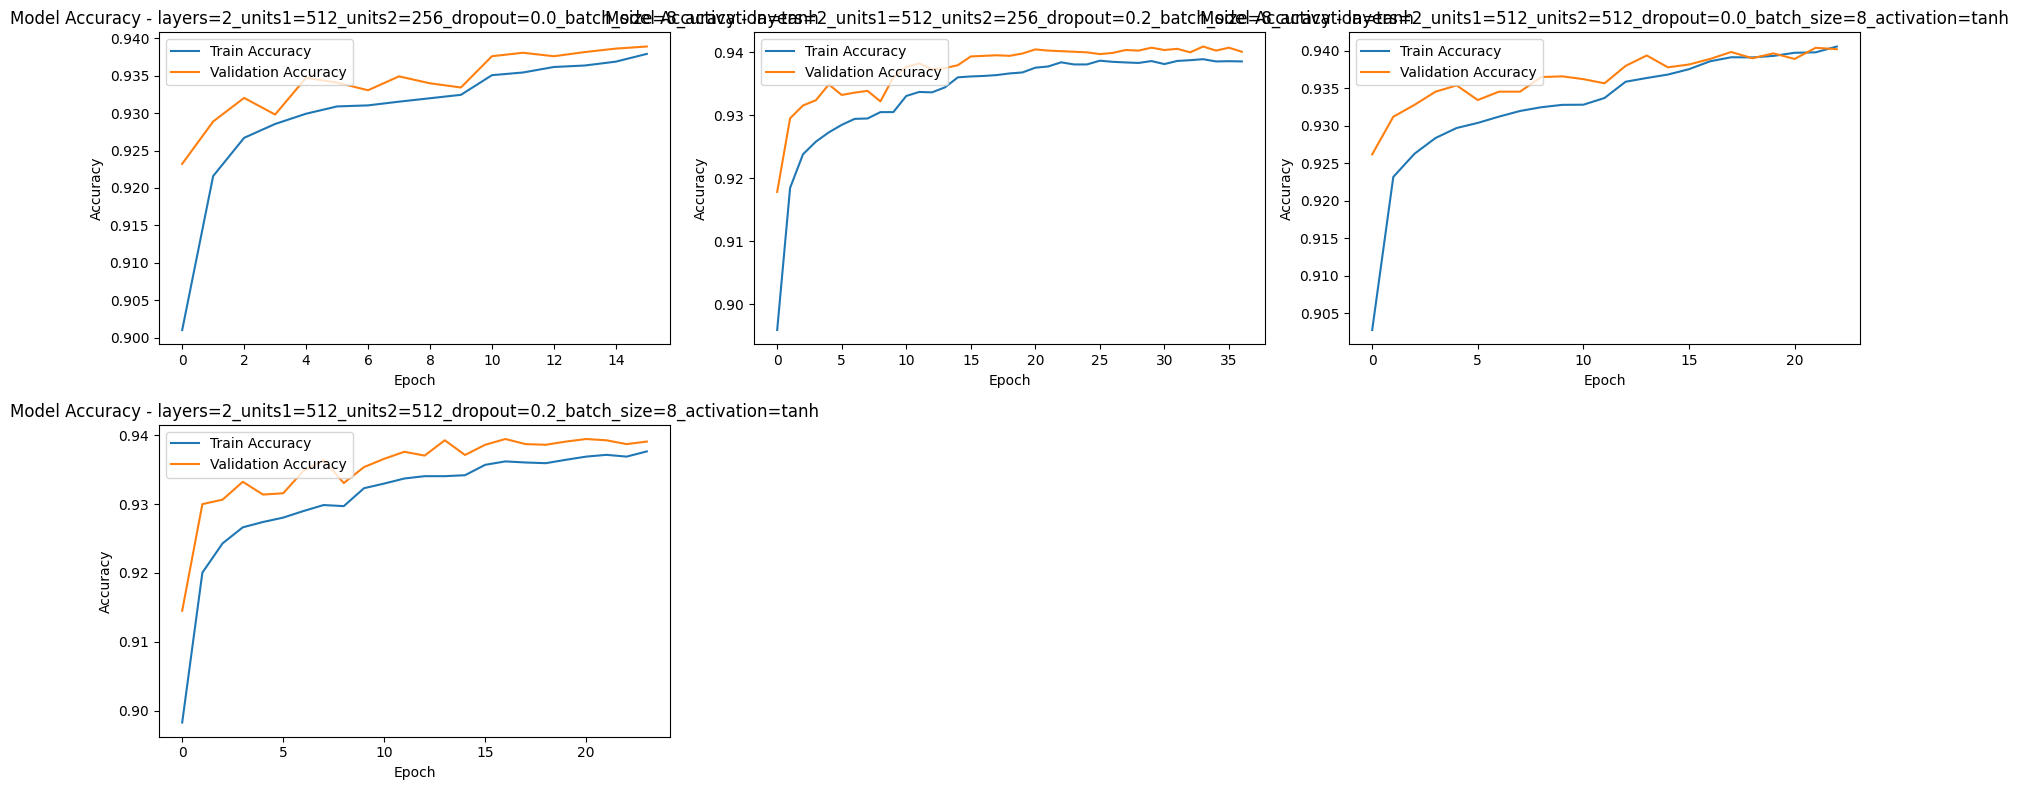

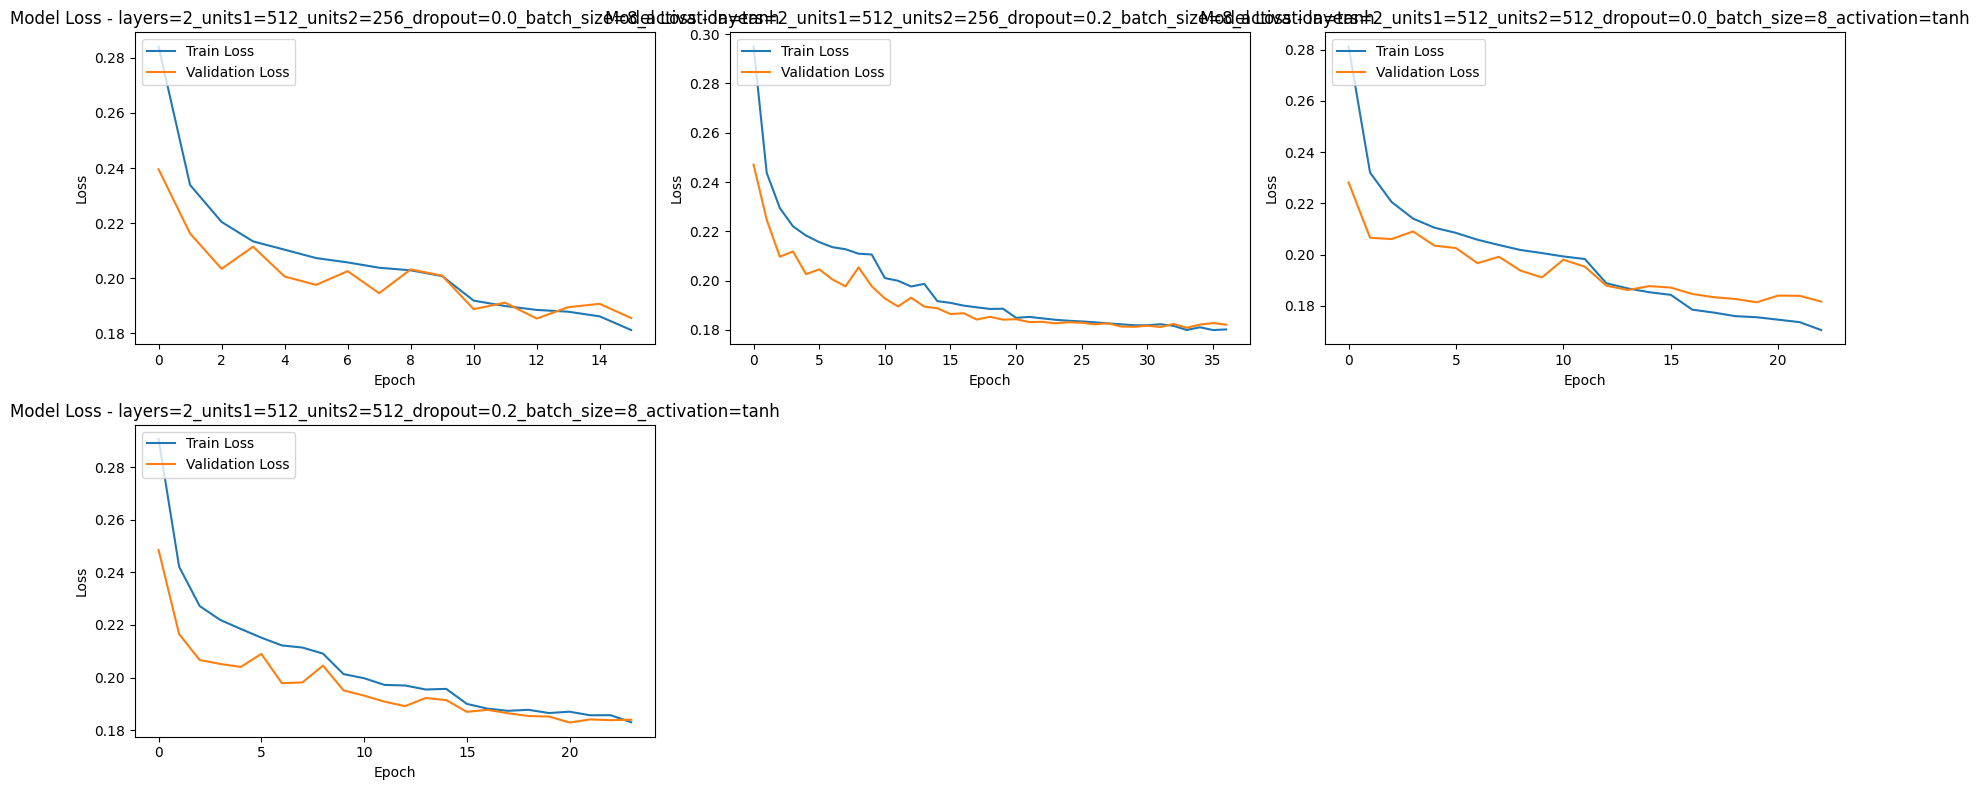

In [21]:
show_histories(histories)

**Best model**

In [35]:
# Best model
# layers=2_units=512_dropout=0.0_batch_size=16_activation=tanh

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# from tensorflow.keras.optimizers import Nadam
import pandas as pd

# Параметри моделі
loss_f = 'binary_crossentropy'
metrics = 'accuracy'

df = pd.read_csv('cleaned_remaining_na_-1.csv')  # Замініть на ваш файл даних

X = df.drop(columns=['id', 'churn',"service_failure_count"])
y = df['churn']

# Поділ на тренувальний, тестовий та валідаційний набори
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# dropout_rate = 0.2 # 0.3,0.4 не маэ сенсу. завжди гірше
batch_size = 16
units1 = 512
units2 = 512
activation = 'tanh'
optimizer =  'adam' #Nadam(learning_rate=0.001)

# Створення моделі
model = Sequential()
model.add(InputLayer(shape=(X_train_scaled.shape[1],)))
model.add(Dense(units1, activation=activation)) #, activation='relu' - результат трохи гірший , kernel_regularizer=l2(1e-4)) - не має сенсу. результат гірше
# model.add(Dropout(dropout_rate))       #  -  не має сенсу, результат гірше
model.add(Dense(units2, activation=activation)) #, activation='relu' , kernel_regularizer=l2(1e-4)
# model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=loss_f, optimizer=optimizer, metrics=[metrics])

# Early stopping та learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# Друк інформації про модель
print('---------------------------------------')
print(f"Training model with 2 layers, units: {units}, batch_size: {batch_size}, activation: {activation}") #layers: {layers}, dropout: {dropout_rate},
# Тренування моделі
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                    epochs=50,batch_size=batch_size,callbacks=[early_stopping, reduce_lr], verbose=1) #     callbacks=[early_stopping, reduce_lr]

# Оцінка моделі на тестових даних
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy for model: {accuracy}")

---------------------------------------
Training model with 2 layers, units: 512, batch_size: 16, activation: tanh
Epoch 1/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8819 - loss: 0.3316 - val_accuracy: 0.9212 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 2/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9142 - loss: 0.2579 - val_accuracy: 0.9160 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 3/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9201 - loss: 0.2419 - val_accuracy: 0.9299 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 4/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9247 - loss: 0.2282 - val_accuracy: 0.8987 - val_loss: 0.2729 - learning_rate: 5.0000e-04
Epoch 5/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9259 - loss: 0.2235 - val_accuracy: 0.8795 - val_loss: 0.2795 - learning_rate: 5.0000e-04
Epoch 6/50
3146/3146 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9308 - loss: 0.2097 - val_accurac

In [6]:
model.save('nn1_midel.keras')

In [29]:
scaler

StandardScaler()

In [36]:
import pickle
def saveScaller(scaler):
    with open('nn1_scaller.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    

In [31]:
with open('nn2_scaller.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
saveScaller(scaler)

In [19]:
with open('nn1_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [27]:
from sklearn.metrics import classification_report
report  = classification_report(y_test, y_pred, output_dict=True)

with open('nn1_report.pkl', 'wb') as file:
    pickle.dump(report, file)

In [26]:
report

'              precision    recall  f1-score   support\n\n           0       0.92      0.93      0.93      4743\n           1       0.95      0.94      0.94      6041\n\n    accuracy                           0.94     10784\n   macro avg       0.93      0.94      0.94     10784\nweighted avg       0.94      0.94      0.94     10784\n'

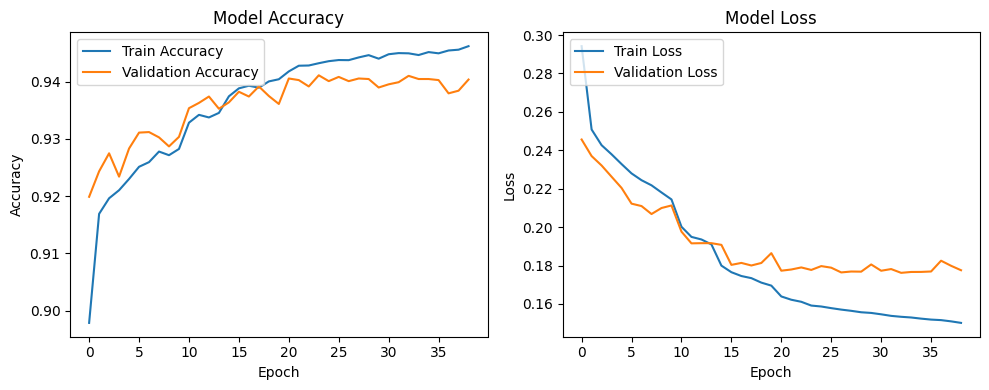

In [4]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots in 1 row
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot - Model Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')

# Second subplot - Model Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper left')

# Adjust layout for a clean look
plt.tight_layout()
plt.show()


In [23]:
file_name = f"l2_adam_units_{units1}+{units2}_batch_{batch_size}_activation_{activation}.h5"
model.save(file_name)